<a href="https://colab.research.google.com/github/ymuto0302/PJ2025/blob/main/MLP_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 全結合型ネットワークを用いた MNIST dataset の分類

### MNIST dataset の可視化

<ipython-input-3-301797092>:36: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


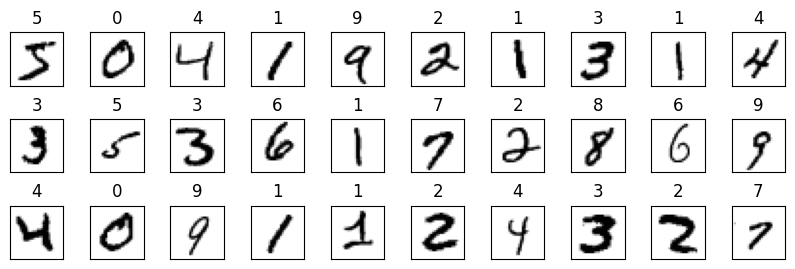

MNISTデータセット情報:
訓練データ数: 60000
画像サイズ: torch.Size([1, 28, 28])
最初の30枚のラベル: [5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9, 4, 0, 9, 1, 1, 2, 4, 3, 2, 7]


In [3]:
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
import numpy as np

# torchvisionからMNIST手書き数字のデータ読み込み
transform = transforms.Compose([
    transforms.ToTensor()
])

# MNISTデータセットのダウンロードと読み込み
mnist_dataset = torchvision.datasets.MNIST(root='./data', train=True,
                                          download=True, transform=transform)

# データセットから直接30枚の画像とラベルを取得
images = []
labels = []

for i in range(30):
    image, label = mnist_dataset[i]
    images.append(image)
    labels.append(label)

# 読み込んだ手書き数字データの画像表示
fig, axes = plt.subplots(3, 10, figsize=(10, 3),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.5, wspace=0.5))

# 確保した描画領域に読み込んだ画像の最初の30枚を表示
for i, ax in enumerate(axes.flat):
    # テンソルをnumpy配列に変換し、形状を(28, 28)に調整
    image_np = images[i].squeeze().numpy()
    ax.imshow(image_np, cmap=plt.cm.gray_r)
    ax.set_title(labels[i])

plt.tight_layout()
plt.show()

# データセット情報の表示
print(f"MNISTデータセット情報:")
print(f"訓練データ数: {len(mnist_dataset)}")
print(f"画像サイズ: {images[0].shape}")

### MNIST dataset の分類

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np

# データのテンソル化 ＆ 標準化のための仕掛け
transform = transforms.Compose([
    transforms.ToTensor(),  # PIL画像をテンソルに変換 & [0, 1] の範囲にスケーリング
    transforms.Normalize((0.5,), (0.5,))  # 標準化 (平均・分散とも 0.5／1チャネル用)
])

# 訓練用データのダウンロード
train_dataset = torchvision.datasets.MNIST(
    root='./data', train=True, download=True, transform=transform
)

# テスト用データのダウンロード
test_dataset = torchvision.datasets.MNIST(
    root='./data', train=False, download=True, transform=transform
)

# データローダーの定義
batch_size = 64  # バッチサイズ
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False
)

print(f"訓練データ数: {len(train_dataset)}")
print(f"テストデータ数: {len(test_dataset)}")

# 最初のバッチを取得
data_iter = iter(train_loader)
images, labels = next(data_iter)

# データの特性
print(f"\n画像の値の範囲: {images.min():.3f} ～ {images.max():.3f}")
print(f"平均値: {images.mean():.3f}")
print(f"標準偏差: {images.std():.3f}")

# 一つの画像を平坦化してみる
flat_image = images[0].reshape(-1)  # 28×28 → 784
print(f"\n平坦化後のサイズ: {flat_image.shape}")
print(f"最初の10個の値: {flat_image[:10]}")


訓練データ数: 60000
テストデータ数: 10000

画像の値の範囲: -1.000 ～ 1.000
平均値: -0.744
標準偏差: 0.609

平坦化後のサイズ: torch.Size([784])
最初の10個の値: tensor([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1.])


In [5]:
# ネットワークの定義
class SimpleNeuralNetwork(nn.Module):
    def __init__(self):
        super(SimpleNeuralNetwork, self).__init__()
        # 入力: 28×28=784 → 隠れ層: 128 → 出力: 10
        self.flatten = nn.Flatten()  # 画像を平坦化
        self.fc1 = nn.Linear(784, 128)  # 入力層 → 隠れ層の構造の設定
        self.relu = nn.ReLU()  # 活性化関数
        self.fc2 = nn.Linear(128, 10)  # 隠れ層 → 出力層の構造の設定

    def forward(self, x):
        """順伝搬"""
        x = self.flatten(x)  # 28×28 → 784に変換
        x = self.fc1(x)      # 入力層から受け取って隠れ層へパス
        x = self.relu(x)     # 活性化
        x = self.fc2(x)      # 隠れ層から出力層へパス
        return x

# モデルのインスタンス化
model = SimpleNeuralNetwork()
print(model)

# パラメータ数の確認
total_params = sum(p.numel() for p in model.parameters())
print(f"（参考）モデルに含まれるパラメータ数: {total_params:,}")

# 損失関数と最適化アルゴリズムの設定
criterion = nn.CrossEntropyLoss()  # 損失関数：交差エントロピー
optimizer = optim.Adam(model.parameters(), lr=0.001)  # 最適化：Adam

print(f"損失関数: {criterion}")
print(f"最適化手法: {optimizer}")

# 学習ループの関数
def train_model(num_epochs=3):
    model.train()  # 訓練モードに設定

    for epoch in range(num_epochs):
        running_loss = 0.0
        correct_predictions = 0
        total_samples = 0

        print(f"\n{epoch+1}エポック目の学習...")

        for batch_idx, (images, labels) in enumerate(train_loader):
            # 勾配を初期化
            optimizer.zero_grad()

            # 順伝搬（前向き計算）
            outputs = model(images)

            # 損失計算
            loss = criterion(outputs, labels)

            # 逆伝播
            loss.backward()

            # パラメータ更新
            optimizer.step()

            # 統計情報の更新
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

            # 200バッチごとに進捗表示
            if (batch_idx+1) % 200 == 0:
                print(f"  バッチ {batch_idx+1}/{len(train_loader)}, 損失: {loss.item():.4f}")

        # エポック終了時の統計
        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = 100 * correct_predictions / total_samples

        print(f"エポック {epoch+1}: 平均損失: {epoch_loss:.4f}  正解率: {epoch_accuracy:.2f}%")

# 学習実行
train_model(num_epochs=3)

# モデルの評価
def test_model():
    model.eval()  # 評価モードに設定
    correct = 0
    total = 0
    test_loss = 0.0

    with torch.no_grad():  # テストでは勾配計算しない
        for images, labels in test_loader:!pip install japanize_matplotlib
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    avg_loss = test_loss / len(test_loader)

    print("------------------------------------------------")
    print(f"テスト結果:  正解数: {correct}/{total}  正解率: {accuracy:.2f}%  平均損失: {avg_loss:.4f}")

    return accuracy

final_accuracy = test_model()

SimpleNeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)
（参考）モデルに含まれるパラメータ数: 101,770
損失関数: CrossEntropyLoss()
最適化手法: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)

1エポック目の学習...
  バッチ 200/938, 損失: 0.4771
  バッチ 400/938, 損失: 0.5932
  バッチ 600/938, 損失: 0.2014
  バッチ 800/938, 損失: 0.1570
エポック 1: 平均損失: 0.3786  正解率: 89.11%

2エポック目の学習...
  バッチ 200/938, 損失: 0.1785
  バッチ 400/938, 損失: 0.2988
  バッチ 600/938, 損失: 0.2247
  バッチ 800/938, 損失: 0.3364
エポック 2: 平均損失: 0.1892  正解率: 94.36%

3エポック目の学習...
  バッチ 200/938, 損失: 0.2265
  バッチ 400/938, 損失: 0.0716
  バッチ 600/938, 損失: 0.1058
  バッチ 800/938, 損失: 0.1114
エポック 3: 平均損失: 0.1345  正解率: 95.91%
------------------------------------------------
テスト結果

### 予測結果の可視化

In [6]:
!pip install japanize_matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 78.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for japanize_matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120257 sha256=b11a15008625be075a91e60365fa5c1784f9312ebad6d9a545d8b387e58a6df5
  Stored in directory: /root/.cache/pip/wheels/da/a1/71/b8faeb93276fed10edffcca20746f1ef6f8d9e071eee8425fc
Successfully built japanize_matplotlib



=== 予測結果の可視化 ===


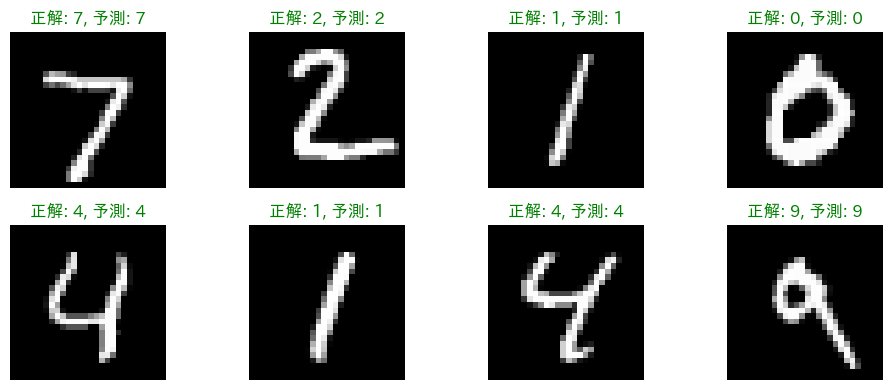

In [7]:
import matplotlib.pyplot as plt
import japanize_matplotlib

# 予測結果の可視化
def show_predictions():
    print("\n=== 予測結果の可視化 ===")

    model.eval()
    data_iter = iter(test_loader)
    images, labels = next(data_iter)

    with torch.no_grad():
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

    # 最初の8個の結果を表示
    fig, axes = plt.subplots(2, 4, figsize=(10, 4))
    for i in range(8):
        row = i // 4
        col = i % 4

        img = images[i].squeeze()
        true_label = labels[i].item()
        pred_label = predicted[i].item()

        # 正解/不正解で色を変える
        color = 'green' if true_label == pred_label else 'red'

        axes[row, col].imshow(img, cmap='gray')
        axes[row, col].set_title(f'正解: {true_label}, 予測: {pred_label}',
                                color=color)
        axes[row, col].axis('off')

    plt.tight_layout()
    plt.show()

show_predictions()
